In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import imageio
from IPython.display import display, clear_output
from tqdm import tqdm
import ipywidgets as widgets
import math 

In [2]:
class GameSimulator:
    """
    Creates the rules for the simulation of bacteria and food growth in the n*n grid
    it covers all the main stages of the simulation: 
    food growth, reseeding, diffusion, food rotting, consumption and reproduction
    """
    def __init__(self, n, bacteria, food, growth_rate, reseed, diffusion_food,diffusion_bacteria, 
                 consumption_rate, reproduction_bacteria):
        self.n = n  
        self.bacteria = bacteria #initial number of bacteria in the system 
        self.food = food #initial number of food in the system 
        self.growth_rate = growth_rate  
        self.diffusion_food = diffusion_food
        self.diffusion_bacteria = diffusion_bacteria
        self.consumption_rate = consumption_rate  
        self.reproduction_bacteria = reproduction_bacteria  
        self.arr = np.random.rand(n, n, 2) #initialize 3 dimensional array with random values
        self.reseed = reseed
        self.step_counter = 0

    def initialize(self):
        """
        Modifies array defined in init function 
        It normalizes it and sets the amount of food and bacteria to match the given parameters 
        """
        self.arr[:, :, 0] = self.arr[:, :, 0] / np.sum(self.arr[:, :, 0]) * self.bacteria
        self.arr[:, :, 1] = self.arr[:, :, 1] / np.sum(self.arr[:, :, 1]) * self.food
        
    def food_growth(self):
        """
        Applies the food growth formula to the food in the array 
        """
        self.arr[:, :, 1] = self.arr[:, :, 1] * (1 + self.growth_rate * (1 - self.arr[:, :, 1] / 100))
                            
        
    def reseeding(self):
        """
        Populates cells with 1 unit of new food with of self.reseed
        mask was created for the array to increase the compuatational speed and avoid loops
        """
        # creating mask
        mask_shape = self.arr[:, :, 1].shape
        mask = np.random.uniform(0, 1, mask_shape) < self.reseed
        # based on the probability output increment food value
        self.arr[:, :, 1] += mask.astype(float)
        
    def diffusion(self, dif, value_index=0):
        """
        Performs both food diffusion and bacteria diffusion
        it decreases a given cell by the diffusion rate 
        and distributes the food/bacteria in Von Naumann neighbourhood 
        mask method is used to increase computational speed
        input: 
            dif (float) -> difusion rate 
            value_index(int) -> 0 to diffuse bacteria
                                1 to diffuse food
        """
        next_arr = self.arr.copy()
        #calculate the diffused amount
        diffused_amount = self.arr[:, :, value_index] * dif
        #create a mask to represent diffusion: 3d array with 4 channels(4 neighboring directions) 
        diffusion_mask = np.zeros((self.n, self.n, 4))
        #np.roll is used to address the periodic boundary condition
        diffusion_mask[:, :, 0] = np.roll(diffused_amount, shift=(0, -1), axis=(0, 1))
        diffusion_mask[:, :, 1] = np.roll(diffused_amount, shift=(0, 1), axis=(0, 1))
        diffusion_mask[:, :, 2] = np.roll(diffused_amount, shift=(-1, 0), axis=(0, 1))
        diffusion_mask[:, :, 3] = np.roll(diffused_amount, shift=(1, 0), axis=(0, 1))
    
        # Diffuse
        diffusion_mask = diffusion_mask / 4
        next_arr[:, :, value_index] -= diffused_amount
        next_arr[:, :, value_index] += diffusion_mask.sum(axis=2)
        
        self.arr = next_arr

    def rotting_food(self):
        """
        Ensures that the food amount is below the bar od 100 units per cell
        all the food that is above will rote 
        """
        #create mask for the cells that have too much food 
        mask = self.arr[:, :, 1] > 100
        #adjust the food amount 
        self.arr[:, :, 1][mask] = 100
        
    def consumption(self): 
        """
        simulates the consumption of food by bacteria in a grid
        calculated the amount of bacteris that did not get food and adjusts the bacteria population
        calculates the resulting food after consumption
        """
        self.arr[:, :, 1] = self.arr[:, :, 1] - self.arr[:, :, 0] * self.consumption_rate #food after consumption
        negative_food = self.arr[:, :, 1] < 0 # if the consumed food is negative
    
        #adjust the number of bacteria based on the food available
        self.arr[:, :, 0][negative_food] = self.arr[:, :, 0][negative_food] + self.arr[:, :, 1][negative_food] / self.consumption_rate
        self.arr[:, :, 1][negative_food] = 0  # reduce food to zero
        negative_bacteria = self.arr[:, :, 0] < 0
        self.arr[:, :, 0][negative_bacteria] = 0
        
    def reproduction(self):
        """
        simulates reproduction of the survived bactria based on the value of the reproduction rate 
        """
        self.arr[:, :, 0] = self.arr[:, :, 0] * (1 + self.reproduction_bacteria)

     

In [3]:
def run_simulation(sim, trials, gif, update_frequency=20):
    """
    Performs the simulation
    shows real time state of the system 
    stores the values of food and bacteria at each step for plotting 
    
    input: 
        sim -> object of the class GameSimulator
        trials(int) -> number of times the simulation will be run
        gif (bool) -> choose if the gif of bacteria dynamics should be displayed in real time or not
        update_frequency(int) -> if gif is displayed, set the image update frequency
        
    output:
        total_bacteria(list) -> contains all the values of the bacteria amount during the simulation 
        total_food(list) -> contains all the values of the bacteria amount during the simulation 
        sim.arr(np array) -> array with food and bacteria at the end of the simulation  
    """
    #initialize lists to stote food and bacteria values
    total_bacteria = []
    total_food = []
    
    if gif:
        plt.figure(figsize=(6, 6))
        plt.title('Real time Bacteria dynamics')
        
    #run simulation 
    for _ in range(trials):
        total_bacteria.append(np.sum(sim.arr[:, :, 0]))
        total_food.append(np.sum(sim.arr[:, :, 1]))

        sim.food_growth()
        sim.reseeding()
        sim.diffusion(dif=sim.diffusion_food, value_index=0)
        sim.rotting_food()
        sim.consumption()
        sim.diffusion(dif=sim.diffusion_bacteria, value_index=1)
        sim.reproduction()
        if gif:
            if _ % update_frequency == 0:
                # Plot the current state of the simulation
                plt.imshow(sim.arr[:, :, 0], cmap='viridis', interpolation='gaussian')
                plt.axis('off')
                clear_output(wait=True)
                display(plt.gcf())
        else:
            pass

    if gif:
        plt.close()
    return total_bacteria, total_food, sim.arr


In [4]:
def plot_data(total_bacteria, total_food, a):
    """
    plots the dynamics of food and bacteria over time 
    input: 
        total_bacteria(list) -> contains all the values of the bacteria amount during the simulation 
        total_food(list) -> contains all the values of the bacteria amount during the simulation 
        a (np array) -> array with the amount of food and bacteria at the end of the simulation
    """
    fig, ax = plt.subplots(1, figsize=(10, 5))
    ax.plot(total_food, label="food")
    ax.plot(total_bacteria, label="bacteria")
    ax.set_title("Total Food and Bacteria Dynamics")
    ax.set_xlabel("Trials")
    ax.set_ylabel("Amount")
    ax.legend()

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax0 = ax[0].imshow(a[:, :, 1], interpolation='gaussian', vmin=np.min(a[:, :, 1]), vmax=np.max(a[:, :, 1]))
    fig.colorbar(ax0, fraction=0.046, pad=0.04)
    ax[0].set_title("Food")

    ax1 = ax[1].imshow(a[:, :, 0], interpolation='gaussian', vmin=np.min(a[:, :, 0]), vmax=np.max(a[:, :, 0]))
    fig.colorbar(ax1, fraction=0.046, pad=0.04)
    ax[1].set_title("Bacteria")



# Testing functions

In [5]:
sim = GameSimulator(n = 5, 
                    bacteria = 100, 
                    food = 100, 
                    growth_rate = 0.5, 
                    reseed = 0.01,  
                    diffusion_food = 0, 
                    diffusion_bacteria = 0, 
                    consumption_rate = 0.5, 
                    reproduction_bacteria = 0.5)

# Testing food growth

In [6]:
#testing food growth function 
sim.growth_rate= 0.1
test1 = np.array([[10, 20, 30, 40, 50],
                    [0, 0, 0, 0, 0,],
                    [0, 0, 0, 0, 0,],
                    [0, 0, 0, 0, 0,],
                    [0, 0, 0, 0, 0,]])

sim.arr[:, :, 1] = test1.copy()
sim.food_growth()
test1_result = test1 *(1 + sim.growth_rate * (1 - test1 / 100))

assert np.allclose(sim.arr[:,:,1], test1_result)
        
        


# Testing food and bacteria diffusion

In [7]:
#testing difusion of food: 
#how the center is distributed and if the periodic boundary condition holds 
sim.arr[:, :, 1] = np.array([[100, 0, 0, 0, 100],
                            [0, 0, 0, 0, 0,],
                            [0, 0, 100, 0, 0,],
                            [0, 0, 0, 0, 0,],
                            [0, 0, 0, 0, 100,]])

sim.diffusion(0.2, value_index=1)

expected_array = np.array([[85, 5, 0, 5, 90],
                           [ 5, 0, 5, 0, 5],
                           [ 0, 5, 80,5, 0],
                           [ 0, 0, 5, 0, 5],
                           [10, 0, 0, 5, 85]])

assert np.allclose(sim.arr[:,:,1], expected_array)

In [8]:
sim.arr[:, :, 0] = np.array([[100, 0, 0, 0, 100],
                            [0, 0, 0, 0, 0,],
                            [0, 0, 100, 0, 0,],
                            [0, 0, 0, 0, 0,],
                            [0, 0, 0, 0, 100,]])

sim.diffusion(0.2, value_index=0)

expected_array = np.array([[85, 5, 0, 5, 90],
                           [ 5, 0, 5, 0, 5],
                           [ 0, 5, 80,5, 0],
                           [ 0, 0, 5, 0, 5],
                           [10, 0, 0, 5, 85]])

assert np.allclose(sim.arr[:,:,0], expected_array)

# Testing food rotting

In [9]:
sim.arr[:, :, 1] = np.array([[150, 299, 380, 100, 100],
                            [200, 300, 400, 500, 100,],
                            [200, 300, 400, 500, 100,],
                            [150, 299, 380, 100, 100],
                            [150, 299, 380, 100, 100]])

sim.rotting_food()

assert np.allclose(np.sum(sim.arr[:, :, 1]), sim.n*sim.n*100)


# Testing consumption 

In [10]:
consumption_rate = 0.5

#bacteria 
#row 1: just enought food
#row 2: too much food (half of food is supposed to be left)
#row 3: not enought food (bacteria is supposed to be changed to 2)
sim.arr[:,:,0]=np.array([[2,2,2,2,2],
                         [1,1,1,1,1],
                         [3,3,3,3,3],
                         [0,0,0,0,0],
                         [0,0,0,0,0]])

sim.arr[:,:,1]=np.array([[1,1,1,1,1],
                         [1,1,1,1,1],
                         [1,1,1,1,1],
                         [1,1,1,1,1],
                         [1,1,1,1,1]])
sim.consumption()

expected_food = np.array([[0,0,0,0,0],
                         [0.5,0.5,0.5,0.5,0.5],
                         [0,0,0,0,0],
                         [1,1,1,1,1],
                         [1,1,1,1,1]])

expected_bacteria = np.array([[2,2,2,2,2],
                             [1,1,1,1,1],
                             [2,2,2,2,2],
                             [0,0,0,0,0],
                             [0,0,0,0,0]])

assert(np.array_equal(sim.arr[:, :, 1], expected_food))
assert(np.array_equal(sim.arr[:, :, 0], expected_bacteria))


# Empirical analysis 

The mean value for food is 783.0, 
The mean value for bacteria is 536.0
(f - b)/f 0.3151486306343935


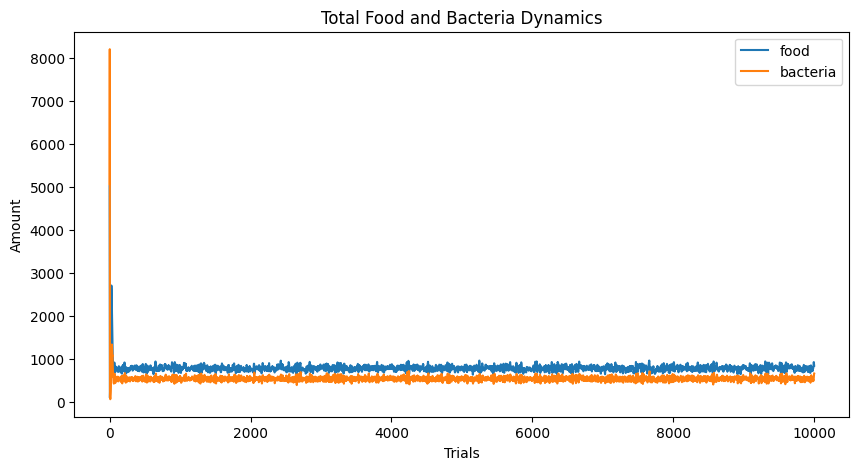

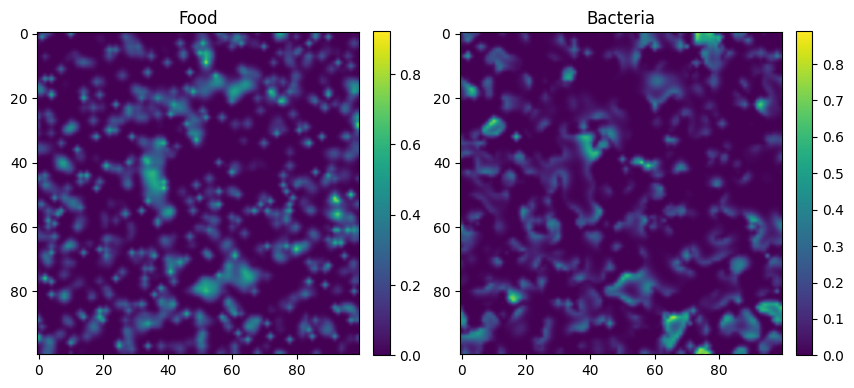

In [11]:
sim = GameSimulator(n = 100, 
                    bacteria = 100, 
                    food = 100, 
                    reseed = 0.01,
                    growth_rate = 0.1, 
                    diffusion_food= 0.5, 
                    diffusion_bacteria = 0.5, 
                    consumption_rate = 0.5, 
                    reproduction_bacteria = 0.5)

total_bacteria, total_food, arr = run_simulation(sim, 10_000, gif = False, update_frequency = 500)
plot_data(total_bacteria, total_food, arr)
print(f'The mean value for food is {np.round(np.mean(total_food))}, \nThe mean value for bacteria is {np.round(np.mean(total_bacteria))}')
print('(f - b)/f', (np.mean(total_food) - np.mean(total_bacteria))/np.mean(total_food))


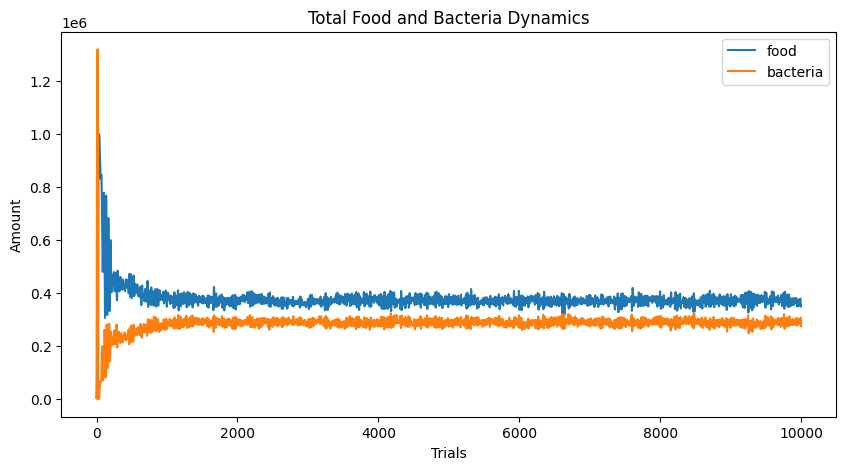

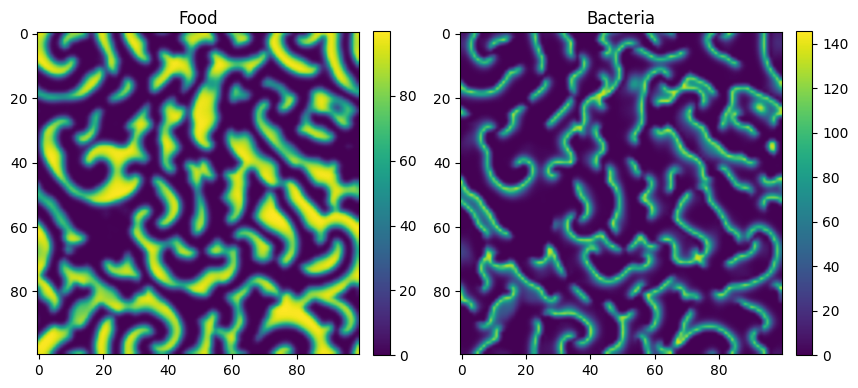

In [12]:
sim = GameSimulator(n = 100, 
                    bacteria = 10, 
                    food = 10, 
                    growth_rate = 2, 
                    reseed = 0.01,  
                    diffusion_food = 0.5, 
                    diffusion_bacteria = 0.5, 
                    consumption_rate = 0.9, 
                    reproduction_bacteria = 0.5)
total_bacteria, total_food, arr = run_simulation(sim, 10000, gif = False, update_frequency = 50)
plot_data(total_bacteria, total_food, arr)

# Theoretical analysis

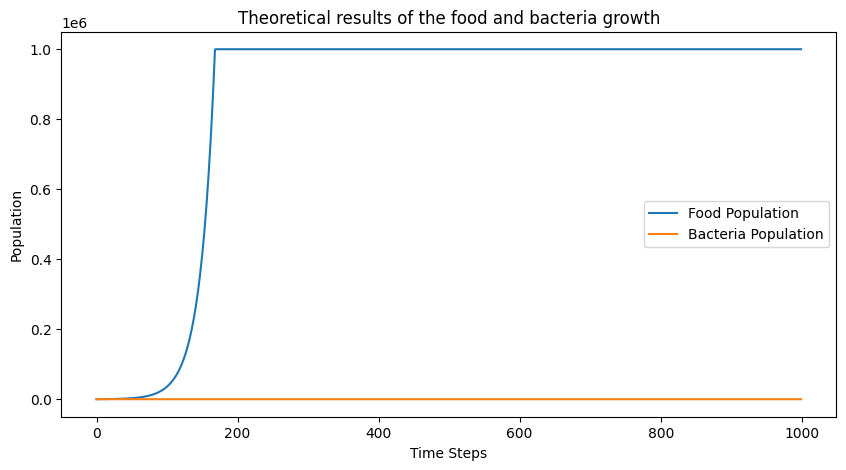

Mean food population over time is 851942.4636293092
Mean bacteria population over time is 0.5953690236914062


In [13]:
def theoretical_analysis(g_f, b_c, r_B, f_r, n, food_max, initial_food, initial_bacteria, time_steps, dt):
    """
    the function performs theoretical analysis of the system based on the Lotka–Volterra equations
    input: 
        g_f (float) -> food growth rate
        b_c (float) -> bacteria consumption rate
        r_B (float) -> bacteria reproduction rate
        f_r (float) -> probability of food reseeding
        n (int) -> grid side, grid size is n*n
        food_max (int) -> max amount of food per cell
        initial_food (int) -> initial amout of food in the system 
        initial_bacteria (int) -> initial amout of bacteria in the system 
        time_steps (int) -> number of steps for the theoretical calculation
        dt (float) -> step size 
    output:
        graph of the bacteria and food change over time 
        mean bacteria population size 
        mean food population size 
    """
    #create empty arrays for storage
    F = np.zeros(time_steps)
    B = np.zeros(time_steps)
    F[0] = initial_food
    B[0] = initial_bacteria

    food_cap = food_max * n * n

    #population dynamics simulation accorsing to the equations 
    for t in range(1, time_steps):
        dF = ((g_f) * F[t-1] + f_r * n * n - b_c * B[t-1]) * dt
        dB = (r_B * (B[t-1] - F[t-1] / b_c)) * dt

        F[t] = min(F[t-1] + dF, food_cap)
        B[t] = max(0, B[t-1] + dB)

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(F, label='Food Population')
    plt.plot(B, label='Bacteria Population')
    plt.xlabel('Time Steps')
    plt.ylabel('Population')
    plt.title('Theoretical results of the food and bacteria growth')
    plt.legend()
    plt.show()

    # Calculate and print mean populations
    mean_food_population = np.mean(F)
    mean_bacteria_population = np.mean(B)
    print(f'Mean food population over time is {mean_food_population}')
    print(f'Mean bacteria population over time is {mean_bacteria_population}')


theoretical_analysis(g_f = 0.5, b_c = 0.5, r_B = 0.5, f_r = 0.01, n = 100,
                    food_max = 100,initial_food = 100, initial_bacteria = 100, time_steps = 1000, dt = 0.1)


mean food population over time is 883140.6239770949
mean bacteria population over time is 421.5513718246497


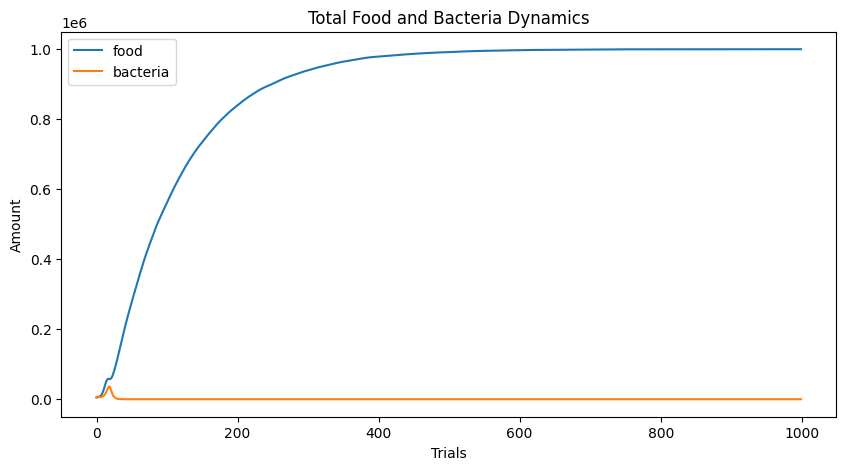

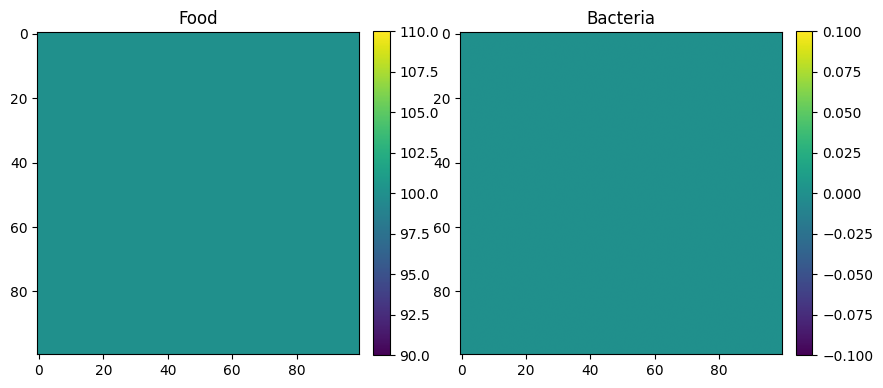

In [14]:
#doing simulation with the same parametrs 
sim = GameSimulator(n = 100, 
                    bacteria = 100, 
                    food = 100, 
                    growth_rate = 0.5, 
                    reseed = 0.01,  
                    diffusion_food = 0, 
                    diffusion_bacteria = 0, 
                    consumption_rate = 0.5, 
                    reproduction_bacteria = 0.5)
total_bacteria, total_food, arr = run_simulation(sim, 1000, gif = False, update_frequency = 50)
plot_data(total_bacteria, total_food, arr)

print(f'mean food population over time is {np.mean(total_food)}')
print(f'mean bacteria population over time is {np.mean(total_bacteria)}')